In [ ]:
# Imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import random
from Fire_Fighter_Env import FireFighterEnv, CellType
import matplotlib.pyplot as plt

In [ ]:
# Policy Network Definition
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.network(x)

In [ ]:
# Policy Gradient Agent Class
class PolicyGradientAgent:
    def __init__(self, env, learning_rate=0.001, gamma=0.95, hidden_size=512):
        self.env = env
        input_size = 6  # agent_pos (2), nearest_fire_pos (2), steps_left (1), score (1)
        self.policy = PolicyNetwork(input_size, hidden_size, 4)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        self.gamma = gamma
        self.log_probs = []
        self.rewards = []
        self.eps = np.finfo(np.float32).eps.item()

    def state_to_tensor(self, state):
        fire_locs = np.argwhere(state['grid'] == CellType.FIRE.value)
        if len(fire_locs) > 0:
            agent_x, agent_y = state['agent_pos']
            distances = np.sqrt(((fire_locs - [agent_x, agent_y])**2).sum(axis=1))
            nearest_idx = np.argmin(distances)
            nearest_fire_pos = fire_locs[nearest_idx]
        else:
            nearest_fire_pos = state['agent_pos']

        agent_pos = torch.FloatTensor(state['agent_pos']) / self.env.size[0]
        fire_pos = torch.FloatTensor(nearest_fire_pos) / self.env.size[0]
        steps_left = torch.FloatTensor([state['steps_left'] / self.env.max_steps])
        score = torch.FloatTensor([state['score'] / 1000.0])

        return torch.cat([agent_pos, fire_pos, steps_left, score]).unsqueeze(0)

    def select_action(self, state):
        state_tensor = self.state_to_tensor(state)
        probs = self.policy(state_tensor)
        m = Categorical(probs)
        action = m.sample()
        self.log_probs.append(m.log_prob(action))
        return action.item(), m.entropy()

    def update_policy(self, entropies, episode):
        discounted_rewards = []
        running_reward = 0
        for r in self.rewards[::-1]:
            running_reward = r + self.gamma * running_reward
            discounted_rewards.insert(0, running_reward)

        discounted_rewards = torch.FloatTensor(discounted_rewards)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / \
                            (discounted_rewards.std() + self.eps)

        entropy_coeff = 0.1 * (1 - episode / 2000)
        policy_loss = []
        for log_prob, reward, entropy in zip(self.log_probs, discounted_rewards, entropies):
            policy_loss.append(-log_prob * reward - entropy_coeff * entropy)

        policy_loss_tensor = torch.stack(policy_loss).sum()  # Total loss for the episode
        avg_loss = policy_loss_tensor.item() / len(self.log_probs)  # Average loss per step

        self.optimizer.zero_grad()
        policy_loss_tensor.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
        self.optimizer.step()

        self.log_probs = []
        self.rewards = []
        return avg_loss  # Return average loss for reporting

In [ ]:
def train_policy_gradient(env, num_episodes=500, max_steps=200):
    agent = PolicyGradientAgent(env)
    best_reward = float('-inf')
    rewards_history = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        entropies = []

        for t in range(max_steps):
            action, entropy = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            fire_locs = np.argwhere(state['grid'] == CellType.FIRE.value)
            if len(fire_locs) > 0:
                old_dist = min(np.sqrt(((fire_locs - state['agent_pos'])**2).sum(axis=1)))
                new_dist = min(np.sqrt(((fire_locs - next_state['agent_pos'])**2).sum(axis=1)))
                if new_dist < old_dist:
                    reward += 20

            agent.rewards.append(reward)
            entropies.append(entropy)
            total_reward += reward
            state = next_state

            if done:
                break

        avg_loss = agent.update_policy(entropies, episode)  # Get average loss
        rewards_history.append(total_reward)
        print(f"Episode {episode + 1}, Total Reward: {total_reward:.2f}, Avg Loss: {avg_loss:.4f}")

        if total_reward > best_reward:
            best_reward = total_reward
            torch.save(agent.policy.state_dict(), 'best_policy.pt')
            print(f"New best reward: {best_reward:.2f} - Model saved")

    return agent, rewards_history

In [ ]:
if __name__ == "__main__":
    env = FireFighterEnv(size=9, fire_spawn_delay=10, max_steps=200)
    print("Training policy gradient agent...")
    trained_agent, rewards_history = train_policy_gradient(env, num_episodes=500)
    print("Training completed!")

Training policy gradient agent...
Episode 1, Total Reward: 250.00, Avg Loss: -0.1308
New best reward: 250.00 - Model saved
Episode 2, Total Reward: -20.00, Avg Loss: -0.1344
Episode 3, Total Reward: -120.00, Avg Loss: -0.1090
Episode 4, Total Reward: -40.00, Avg Loss: -0.1630
Episode 5, Total Reward: -100.00, Avg Loss: -0.1157
Episode 6, Total Reward: 400.00, Avg Loss: -0.0996
New best reward: 400.00 - Model saved
Episode 7, Total Reward: 70.00, Avg Loss: -0.1204
Episode 8, Total Reward: 250.00, Avg Loss: -0.1386
Episode 9, Total Reward: 250.00, Avg Loss: -0.1425
Episode 10, Total Reward: 150.00, Avg Loss: -0.1431
Episode 11, Total Reward: 110.00, Avg Loss: -0.1486
Episode 12, Total Reward: -120.00, Avg Loss: -0.1340
Episode 13, Total Reward: 370.00, Avg Loss: -0.1561
Episode 14, Total Reward: -40.00, Avg Loss: -0.1296
Episode 15, Total Reward: 520.00, Avg Loss: -0.1413
New best reward: 520.00 - Model saved
Episode 16, Total Reward: 500.00, Avg Loss: -0.1611
Episode 17, Total Reward: 1

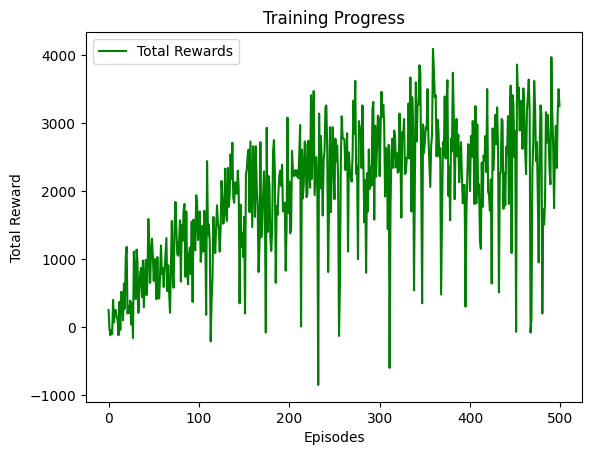

In [ ]:

# Your original plotting function
def plot_training(rewards):
    plt.plot(rewards, 'g-', label='Total Rewards')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.legend()
    plt.show()

plot_training(rewards_history)